# Notebook for the blog Faster Forecasting using Ray AIR Distributed Computing

This notebook is to accompany blog "Faster Time Series Forecasting with Ray AIR".

**TODO add medium link once blog is published**


# Contents
 1. [Multi-model training using Ray core multiprocessing](#core_multiprocessing) 
 2. [Multi-model tuning using Ray Tune with Ray AIR](#tune_air)
 3. [Load a model from checkpoint](#restore_model)
 4. [Create a validation forecast from restored checkpoint model](#inference)
 5. [Deploy a batch predictor from checkpoint using Ray Serve](#serve_air)

## Multi-model training using Ray core multiprocessing <a class="anchor" id="core_multiprocessing"></a>

Import required libraries, including [Prophet](https://facebook.github.io/prophet/) and [Ray](https://towardsdatascience.com/modern-parallel-and-distributed-python-a-quick-tutorial-on-ray-99f8d70369b8).

In [1]:
import time, dateutil
from dateutil.relativedelta import relativedelta
from datetime import datetime, timedelta
from typing import Tuple, List
import numpy as np
import pandas as pd
# Import libraries for reading from partitioned parquet.
import pyarrow.parquet as pq
import pyarrow.dataset as pds
# Import forecasting libraries.
import prophet
from prophet import Prophet

print(f"prophet: {prophet.__version__}")
# Import Ray's multiprocessing library.
import ray
from ray.util.multiprocessing import Pool 
import tqdm

prophet: 1.0


In [2]:
# Define some global variables.
s3_partitions = pds.dataset(
    "s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/",
    partitioning=["month"],
)
S3_FILES = [f"s3://anonymous@{file}" for file in s3_partitions.files]
MIN_DATE = datetime(2018, 11, 1)
MAX_DATE = datetime(2019, 7, 30)
SAMPLE_UNIQUE_ID = 141
FORECAST_LENGTH = 28
TARGET = "trip_distance"

# For benchmarking purposes, we can print the times of various operations.
# In order to reduce clutter in the output, this is set to False by default.
PRINT_TIMES = False

def print_time(msg: str):
    if PRINT_TIMES:
        print(msg)

# To speed things up, we’ll only use a small subset of the full dataset consisting of two last months of 2019.
# You can choose to use the full dataset for 2018-2019 by setting the SMOKE_TEST variable to False.
SMOKE_TEST = False

# Use smoke testing or not.
models_to_train = S3_FILES[-1:] if SMOKE_TEST else S3_FILES

# Display what data will be used.
print(f"data files: {models_to_train}")


data files: ['s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/01/data.parquet/4d6bc4368704460d90c92c22e05a2220_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/02/data.parquet/e817946252d1409b93964685130e76cb_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/03/data.parquet/0b7e5121a4904c64be5e91ceec0eee2f_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/04/data.parquet/f40c2c2806e548bfac8336de9c19a423_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/05/data.parquet/a5de27164fda47988dec2576685656ae_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/06/data.parquet/df104576ffed4e308b72941df90f7790_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/07/data.parquet/ccdef45e50de4678b7e589155f372a3d_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/20

In [3]:
if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-01-23 16:48:56,736	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.15
Ray version:,2.2.0
Dashboard:,http://127.0.0.1:8265


In [4]:
print(ray.cluster_resources())

{'memory': 6448316416.0, 'object_store_memory': 2147483648.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0}


In [5]:
##########
# STEP 1. Define a Python function to read and preprocess a file of data. 
##########
def preprocess_data(file_path: str) -> Tuple[pd.DataFrame, np.int32]:
    """Read a S3 file, aggregate timestamp Daily level.
       Prophet requires timestamp is called 'ds' and target_value called 'y'.
       Prophet requires at least 2 data points per timestamp.
       StatsForecast requires taxi location is called 'unique_id'.

    Args:
        file_path (str): _description_

    Returns:
        Tuple[pd.DataFrame, np.int32]: _description_
    """
    
    # Read a single pyarrow parquet S3 file.
    data = pq.read_table(file_path,
           filters=[ ("pickup_location_id", "=", SAMPLE_UNIQUE_ID) ],
           columns=[ "pickup_at", "pickup_location_id", TARGET ])\
           .to_pandas()
    
    # Transform data.
    data["ds"] = data["pickup_at"].dt.to_period("D").dt.to_timestamp()
    data.rename(columns={TARGET: "y"}, inplace=True)
    data.rename(columns={"pickup_location_id": "unique_id"}, inplace=True)
    data.drop("pickup_at", inplace=True, axis=1)
    unique_id = data["unique_id"][0]
    return data, unique_id

##########
# STEP 2. Define Python functions to train and evaluate a model on a file of data.
##########
def train_model(file_path: str) -> Tuple[pd.DataFrame, 
                                         pd.DataFrame, 
                                         'prophet.forecaster.Prophet', 
                                         np.int32]:
    
    # Prepare data from a single S3 file.
    data, unique_id = preprocess_data(file_path)

    # Split data into train, test.
    train_end = data.ds.max() - relativedelta(days=FORECAST_LENGTH - 1)
    train_df = data.loc[(data.ds <= train_end), :].copy()
    test_df = data.iloc[-(FORECAST_LENGTH):, :].copy()
    
    # Define Prophet model with 75% confidence interval.
    model = Prophet(interval_width=0.75, seasonality_mode="multiplicative")      

    # Train and fit Prophet model.
    model = model.fit(train_df[["ds", "y"]])
    return train_df, test_df, model, unique_id

def evaluate_model(model: 'prophet.forecaster.Prophet', train: pd.DataFrame, 
    valid: pd.DataFrame, input_value: np.int32) -> Tuple[float, pd.DataFrame]:

    # Inference model using FORECAST_LENGTH.
    future_dates = model.make_future_dataframe(
        periods=FORECAST_LENGTH, freq="D")
    future = model.predict(future_dates)
    
    # Merge in the actual y-values.
    future = pd.merge(future, train[['ds', 'y']], on=['ds'], how='left')
    future = pd.merge(future, valid[['ds', 'y']], on=['ds'], how='left')
    future['y'] = future.y_x.combine_first(future.y_y)
    future.drop(['y_x', 'y_y'], inplace=True, axis=1)
    future['unique_id'] = input_value
    
    # Calculate mean absolute forecast error.
    temp = future.copy()
    temp["forecast_error"] = np.abs(temp["yhat"] - temp["y"])
    temp.dropna(inplace=True)
    error = np.mean(temp["forecast_error"])
    return error, future

############
# STEP 3.  Define a calling function which calls all the above functions,
#          and will be called in parallel for every data file.
############
def train__and_evaluate(file_path: str) -> Tuple[pd.DataFrame, 
    'prophet.forecaster.Prophet', pd.DataFrame, float, np.int16]:
    
    # Read S3 file and train a Prophet model.
    train_df, valid_df, model, unique_id = train_model(file_path)
    
    # Inference model and evaluate error.
    error, future = evaluate_model(model, train_df, valid_df, unique_id)
    return valid_df, model, future, error, unique_id

### Regular Python

In [ ]:
start = time.time()

for file in models_to_train:
    print("Training model serially", file)
    test_df, model, forecast_df, error, unique_id = train__and_evaluate(file)
    print(test_df.shape, type(model), forecast_df.shape, type(error), type(unique_id))

time_regular_python = time.time() - start
print(f"Total number of models: {len(models_to_train)}")
print(f"TOTAL TIME TAKEN: {time_regular_python/60:.2f} minutes")

# Ran on 1-node AWS cluster of m5.2xlarge with 8 CPU
# Total number of models: 12
# TOTAL TIME TAKEN: 3.08 minutes


### Ray Multiprocessing

[Ray Multiprocessing](https://docs.ray.io/en/latest/ray-more-libs/multiprocessing.html) is easier to use than [Ray Core APIs](https://docs.ray.io/en/latest/ray-core/walkthrough.html).  Also, Ray Multiprocessing is more robust than regular [Python multiprocessing](https://docs.python.org/3/library/multiprocessing.html).

Below we run the regular Python functions, defined above, in a Ray Multiprocessing pool.

In [ ]:
start = time.time()
# Create a pool, where each worker is assigned 1 CPU by Ray.
pool = Pool(ray_remote_args={"num_cpus": 1})

# Use the pool to run `train_model` on the data, in batches of 1.
iterator = pool.imap_unordered(train__and_evaluate, models_to_train, chunksize=1)

# Track the progress using tqdm and retrieve the results into a list.
results = list(tqdm.tqdm(iterator, total=len(models_to_train)))

# Print some training stats.
time_ray_multiprocessing = time.time() - start
print(f"Total number of models: {len(results)}")
print(f"TOTAL TIME TAKEN: {time_ray_multiprocessing/60:.2f} minutes")

assert len(results) == len(models_to_train)
# print(type(results[0][0]), type(results[0][1]), type(results[0][2]), 
#       type(results[0][3]), type(results[0][4]))

# Ran on 1-node AWS cluster of m5.2xlarge with 8 CPU
# Chunksize=1
# Total number of models: 12
# TOTAL TIME TAKEN: 1.25 minutes


In [ ]:
# Calculate the speed-up between serial Python and Ray Multiprocessing Pool

speedup = time_regular_python / time_ray_multiprocessing
print(f"Speedup from running Ray Multiprocessing vs serial Python: {np.round(speedup, 1)}x"
      f", or {(np.round(speedup, 0)-1) * 100}%")

# Ran on my mac laptop with 8 CPU
# Speedup from running Ray Multiprocessing vs serial Python: 3.7x, or 300.0%

# Ran on 1-node AWS cluster of m5.2xlarge with 8 CPU
# Speedup from running Ray Multiprocessing vs serial Python: 2.5x, or 100.0%


## Multi-model training using Ray Tune with Ray AIR <a class="anchor" id="tune_air"></a>

The astute reader may have noticed, in the previous section, Ray Multiprocessing required the data to already be organized into one file per model you want to train. **But what if your data isn't already organized by model?** With Ray AIR, you can preprocess data in the same pipeline while training different models. 

Another problem with the previous section, **what if you want to mix-and-match more than one forecasting algorithm at a time?** Ray Tune, which is part of Ray AIR, lets you run parallel trials to find the best choice of algorithm and hyperparameters, per segment of data.

**Below are the general steps to preprocess data and automatically tune models from any combination of AI/ML Python libraries using distributed computing with [Ray AIR](https://docs.ray.io/en/latest/ray-air/getting-started.html) and [APIs](https://docs.ray.io/en/latest/ray-air/package-ref.html):**

<ol>
    <li>Define Python functions <b>`preprocess`</b> to read and prepare a segment of data.
    <li>Define Python functions to `<b>train`</b> and <b>`evaluate`</b> a model on a segment of data.
    <li>Define a calling function <b>`train_models`</b>, which calls all the above functions, and will be called in parallel for every permutation in the Tune search space!<br>
    Inside this <a href="https://docs.ray.io/en/latest/tune/api_docs/trainable.html#trainable-docs">`train_models`</a> function:
    <ul>
        <li>📖 The input parameters must include a config dictionary argument.
        <li>📈 The tuning metric (a model's loss or error) must be calculated and reported using session.report().
        <li>✔️ Checkpoint (save) the model is recommended for fault tolerance and easy deployment later.
    </ul>
    <li><b>Configure distributed compute scaling</b>.
    <li><b>Define a Ray Tune search space</b> of all training parameters.
    <li>(Optional) Specify a hyperparameter search strategy.
    <li><b>Run the experiment</b> using Ray AIR APIs.
</ol>

Below is the additional code we would add.

In [9]:
import os
num_cpu = os.cpu_count()

print(f"num_cpus: {num_cpu}")
# Import another forecasting library.
import statsforecast
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

print(f"statsforecast: {statsforecast.__version__}")
# Import Ray AIR libraries.
from ray import air, tune
from ray.air import session, ScalingConfig
from ray.air.checkpoint import Checkpoint
RAY_IGNORE_UNHANDLED_ERRORS=1

num_cpus: 8
statsforecast: 1.3.1


In [10]:
# Obtain all location IDs
all_location_ids = (
    pq.read_table(S3_FILES[0], columns=["pickup_location_id"])[
        "pickup_location_id"
    ]
    .unique()
    .to_pylist()
)
all_location_ids.remove(264)
all_location_ids.remove(265)
all_location_ids.remove(199)
print(len(all_location_ids)) #256

# Use smoke testing or not.
files_to_use = S3_FILES[-1:] if SMOKE_TEST else S3_FILES
models_to_train = [173, 141] if SMOKE_TEST else all_location_ids[0:10] + [165, 237]
algorithms_to_use = ["prophet_additive"] if SMOKE_TEST \
    else ["prophet_additive", "prophet_multiplicative", "arima"]

# Display what data will be used.
print(f"files to use: {files_to_use}")
print(f"models to train: {models_to_train}")
print(f"algorithms to use: {algorithms_to_use}")

256
files to use: ['s3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/01/data.parquet/4d6bc4368704460d90c92c22e05a2220_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/02/data.parquet/e817946252d1409b93964685130e76cb_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/03/data.parquet/0b7e5121a4904c64be5e91ceec0eee2f_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/04/data.parquet/f40c2c2806e548bfac8336de9c19a423_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/05/data.parquet/a5de27164fda47988dec2576685656ae_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/06/data.parquet/df104576ffed4e308b72941df90f7790_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_year/2018/07/data.parquet/ccdef45e50de4678b7e589155f372a3d_000000.parquet', 's3://anonymous@air-example-data/ursa-labs-taxi-data/by_y

<br>

The `preprocess_data` function below is exactly the same as before except it takes in a list of files instead of a single file.

In [11]:
##########
# STEP 1. Define Python functions to read and prepare a segment of data.
##########

# Function to read a pyarrow.Table object using pyarrow parquet.
def read_data(file: str, sample_id: np.int32) -> pd.DataFrame:

    df = pq.read_table(
        file,
        filters=[
            ("pickup_at", ">=", MIN_DATE),
            # ("pickup_at", "<=", MAX_DATE),
            ("passenger_count", ">", 0),
            ("trip_distance", ">", 0),
            ("fare_amount", ">", 0),
            ("pickup_location_id", "not in", [264, 265]),
            ("dropoff_location_id", "not in", [264, 265]),
            ("pickup_location_id", "=", sample_id),
        ],
        columns=[
            "pickup_at",
            "dropoff_at",
            "pickup_location_id",
            "dropoff_location_id",
            "passenger_count",
            "trip_distance",
            "fare_amount",
        ],
    ).to_pandas()
    return df

# Function to transform a pandas dataframe
def transform_df(input_df: pd.DataFrame) -> pd.DataFrame:
    df = input_df.copy()

    # calculate trip_duration
    df["trip_duration"] = (df["dropoff_at"] - df["pickup_at"]).dt.seconds
    # filter trip_durations > 1 minute and less than 24 hours
    df = df[df["trip_duration"] > 60]
    df = df[df["trip_duration"] < 24 * 60 * 60]

    # Prophet requires timstamp is 'ds' and target_value name is 'y'
    # Prophet requires at least 2 data points per timestamp
    # StatsForecast requires location name is 'unique_id'

    # add year_month_day and concat into a unique column to use as groupby key
    df["ds"] = df["pickup_at"].dt.to_period("D").dt.to_timestamp()
    df["loc_year_month_day"] = (
        df["pickup_location_id"].astype(str)
        + "_"
        + df["pickup_at"].dt.year.astype(str)
        + "_"
        + df["pickup_at"].dt.month.astype(str)
        + "_"
        + df["pickup_at"].dt.day.astype(str)
    )
    # add target_value quantity for groupby count later
    df["y"] = 1
    # rename pickup_location_id to unique_id
    df.rename(columns={"pickup_location_id": "unique_id"}, inplace=True)
    # keep only unnecessary columns
    df = df[['loc_year_month_day', 'unique_id', 'ds', 'y']].copy()

    # groupby aggregregate
    g = df.groupby("loc_year_month_day").agg(
        {"unique_id": min, "ds": min, "y": sum}
    )
    # having num rows in group > 2
    g.dropna(inplace=True)
    g = g[g["y"] > 2].copy()

    # Drop groupby variable since we do not need it anymore
    g.reset_index(inplace=True)
    g.drop(["loc_year_month_day"], axis=1, inplace=True)

    return g

def preprocess_per_uniqueid(
    s3_files: List[str], 
    sample_location_id: np.int32) -> pd.DataFrame:

    # Load data.
    df_list = [read_data(f, sample_location_id) for f in s3_files]
    df_raw = pd.concat(df_list, ignore_index=True)
    # Abort Tune to avoid Tune Error if df has too few rows
    if df_raw.shape[0] < FORECAST_LENGTH:
        print_time(
            f"Location {sample_location_id} has only {df_raw.shape[0]} rows"
        )
        session.report(dict(error=None))
        return None

    # Transform data.
    df = transform_df(df_raw)
    # Abort Tune to avoid Tune Error if df has too few rows
    if df.shape[0] < FORECAST_LENGTH:
        print_time(f"Location {sample_location_id} has only {df.shape[0]} rows")
        session.report(dict(error=None))
        return None
    else:
        df.sort_values(by="ds", inplace=True)

    return df

<br>

The `train_model` functions below are exactly the same as before except they take in a list of files instead of a single file.

In [12]:
##########
# STEP 2. Define Python functions to train and evaluate a model on a segment of data.
##########

def train_prophet(
    s3_files: List[str], 
    sample_unique_id: np.int32,
    model_type: str) -> Tuple[pd.DataFrame, pd.DataFrame, 
                              'prophet.forecaster.Prophet', np.int32]:
    
    # Prepare data from a list of S3 files.
    data = preprocess_per_uniqueid(s3_files, sample_unique_id)

    # Split data into train, test.
    train_end = data.ds.max() - relativedelta(days=FORECAST_LENGTH - 1)
    train_df = data.loc[(data.ds <= train_end), :].copy()
    test_df = data.iloc[-(FORECAST_LENGTH):, :].copy()
    
    # Define Prophet model with 75% confidence interval.
    if model_type == "prophet_additive":
        model = Prophet(interval_width=0.75, seasonality_mode="additive")
    elif model_type == "prophet_multiplicative":
        model = Prophet(interval_width=0.75, seasonality_mode="multiplicative")     

    # Train and fit Prophet model.
    model = model.fit(train_df[["ds", "y"]])

    return train_df, test_df, model

# Function to train an ARIMA model for a segment of data from list of files.
def train_arima(
    s3_files: List[str], 
    sample_unique_id: np.int32) -> Tuple[pd.DataFrame, pd.DataFrame, 
                                         'statsforecast.models.AutoARIMA', 
                                          np.int32]:
    
    # Prepare data from a list of S3 files.
    data = preprocess_per_uniqueid(s3_files, sample_unique_id)

    # Split data into train, test.
    train_end = data.ds.max() - relativedelta(days=FORECAST_LENGTH - 1)
    train_df = data.loc[(data.ds <= train_end), :].copy()
    test_df = data.iloc[-(FORECAST_LENGTH):, :].copy()
    
    # Define ARIMA model with daily frequency which implies seasonality = 7.
    models = [AutoARIMA(season_length=7, approximation=True)]

    # Train and fit ARIMA model.
    try:
        model = StatsForecast(df=train_df, models=models, freq="D")
    except:
        print(f"ARIMA error processing location: {sample_unique_id}")

    return train_df, test_df, model

def evaluate_arima(
    model: "statsforecast.models.AutoARIMA", 
    test: pd.DataFrame) -> Tuple[float, pd.DataFrame]:

    # Inference model using test data.
    forecasts_df = model.forecast(h=FORECAST_LENGTH).reset_index()
    
    # Merge in the actual y-values.
    future = forecasts_df.merge(test, on=['unique_id', 'ds'], how="outer")
    future.dropna(inplace=True)
    future.rename(columns={'AutoARIMA': 'yhat'}, inplace=True)
    
    # Calculate mean absolute forecast error.
    temp = future.copy()
    temp["forecast_error"] = np.abs(temp["yhat"] - temp["y"])
    temp.dropna(inplace=True)
    error = np.mean(temp["forecast_error"])

    return error, future

<br>

The `train_models` function is exactly the same as `train_and_evaluate` except it takes in a list of files instead of a single file, it trains the algorithm passed in the config, and does checkpointing.
<br>

In [ ]:
############
# STEP 3.  Define a calling function `train_models`, which calls all 
#          the above functions, and will be called in parallel for every 
#          permutation in the Tune search space.
############
def train_models(config: dict) -> None:
    
    # Get Tune parameters
    file_list = config['params']['file_list']
    model_type = config['params']['algorithm']
    sample_unique_id = config['params']['location']
    
    # Train model.
    if model_type == "arima":
        # Train and fit the Prophet model.
        train_df, valid_df, model = \
            train_arima(file_list, sample_unique_id)

        # Inference model and evaluate error.
        error, future = \
            evaluate_arima(model, valid_df)

    else:
        # Train and fit the Prophet model.
        train_df, valid_df, model = \
            train_prophet(file_list, sample_unique_id, model_type)

        # Inference model and evaluate error.
        error, future = evaluate_model(model, train_df, valid_df, sample_unique_id)
    
    # Define a model checkpoint using AIR API.
    # https://docs.ray.io/en/latest/tune/tutorials/tune-checkpoints.html
    checkpoint = ray.air.checkpoint.Checkpoint.from_dict(
        {
            "model": model,
            "valid_df": valid_df,
            "forecast_df": future,
            "location_id": sample_unique_id,
        }
    )
    # Save checkpoint and report back metrics, using ray.air.session.report()
    metrics = dict(error=error)
    session.report(metrics, checkpoint=checkpoint)


In [13]:
############
# STEP 4. Customize distributed compute scaling.
# https://docs.ray.io/en/master/train/config_guide.html
############
num_training_workers = min(num_cpu - 2, 32)
scaling_config = ScalingConfig(
    # Number of distributed workers.
    num_workers=num_training_workers,
    # Turn on/off GPU.
    use_gpu=False,
    # Specify resources used for trainer.
    trainer_resources={"CPU": 1},
    # Try to schedule workers on different nodes.
    placement_strategy="SPREAD",
)

############
# STEP 5. Define a search space dict of all config parameters.
# https://docs.ray.io/en/latest/ray-air/tuner.html
############
search_space = {
    "scaling_config": scaling_config,
    "params": {
        "file_list": tune.grid_search([files_to_use]),
        "algorithm": tune.grid_search(algorithms_to_use),
        "location": tune.grid_search(models_to_train),
    },
}

# Optional STEP 6. Specify the hyperparameter tuning search strategy.
# https://docs.ray.io/en/latest/tune/key-concepts.html#search-algorithms


In [14]:
############
# STEP 7. Run the experiment with Ray AIR APIs.
# https://docs.ray.io/en/latest/ray-air/examples/huggingface_text_classification.html
############
if ray.is_initialized():
    ray.shutdown()
start = time.time()

# Define a tuner object.
tuner = tune.Tuner(
        train_models,
        param_space=search_space,
        tune_config=tune.TuneConfig(
            metric="error",
            mode="min",
        ),
        run_config=air.RunConfig(
            # Redirect logs to relative path instead of default ~/ray_results/.
            local_dir="my_Tune_logs",
            # Specify name to make logs easier to find in log path.
            name="tune_nyc",
        ),
    )

# Fit the tuner object.
results = tuner.fit()

time_ray_tune = time.time() - start
print(f"Total number of models: {len(results)}")
print(f"TOTAL TIME TAKEN: {time_ray_tune/60:.2f} minutes")

# Ran on 2-node AWS cluster of m5.2xlarge with 8 CPU
# Total number of models: 36
# TOTAL TIME TAKEN: 1.54 minutes

2023-01-22 18:54:33,558	INFO tune.py:887 -- Initializing Ray automatically.For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run`.
2023-01-22 18:54:33,559	INFO worker.py:1230 -- Using address localhost:9031 set in the environment variable RAY_ADDRESS
2023-01-22 18:54:33,560	INFO worker.py:1352 -- Connecting to existing Ray cluster at address: 10.0.80.127:9031...
2023-01-22 18:54:33,563	INFO worker.py:1529 -- Connected to Ray cluster. View the dashboard at https://console.anyscale.com/api/v2/sessions/ses_zl6k8uzbges47yk66ufpvqtram/services?redirect_to=dashboard 


(scheduler +7s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +7s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +11s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +17s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +24s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +29s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +35s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +40s) Failed to launch 1 node(s) of type worker-node-type-0.


(train_models pid=1579) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1579) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
(train_models pid=1647) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1647) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=1579) 
(train_models pid=1579) Initial log joint probability = -0.656032
(train_models pid=1579) Iteration  1. Log joint probability =    32.2884. Improved by 32.9445.
(train_models pid=1579) Iteration  2. Log joint probability =    50.9181. Improved by 18.6297.
(train_models pid=1579) Iteration  3. Log joint probability =    56.2485. Improved by 5.33034.
(train_models pid=1579) Iteration  4. Log joint probability =     56.381. Improved by 0.132481.
(train_models pid=1579) Iteration  5. Log joint probability =    56.4789. Improved by 0.0979055.
(train_models pid=1579) Iteration  6. Log joint probability =    56.5383. Improved by 0.0594227.
(train_models pid=1647) 
(train_models pid=1647) Initial log joint probability = -0.656032
(train_models pid=1647) Iteration  1. Log joint probability =    31.6017. Improved by 32.2578.
(train_models pid=1647) Iteration  2. Log joint probability =    43.3712. Improved by 11.7694.
(train_models pid=1647) Iteration  3. Log joint proba

(train_models pid=1657) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1657) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=1657) Iteration 38. Log joint probability =    58.4952. Improved by 5.7983e-06.
(train_models pid=1657) Iteration 39. Log joint probability =    58.4952. Improved by 9.17095e-06.
(train_models pid=1657) Iteration 40. Log joint probability =    58.4952. Improved by 3.21781e-06.
(train_models pid=1657) Iteration 41. Log joint probability =    58.4952. Improved by 4.71325e-06.
(train_models pid=1657) Iteration 42. Log joint probability =    58.4952. Improved by 1.32445e-06.
(train_models pid=1657) Iteration 43. Log joint probability =    58.4952. Improved by 1.88836e-06.
(train_models pid=1657) Iteration 44. Log joint probability =    58.4952. Improved by 9.12946e-07.
(train_models pid=1657) Iteration 45. Log joint probability =    58.4952. Improved by 5.05963e-07.
(train_models pid=1657) Iteration 46. Log joint probability =    58.4952. Improved by 1.15884e-07.
(train_models pid=1657) Iteration 47. Log joint probability =    58.4952. Improved by 2.29065e-07.
(train_mode

(train_models pid=1651) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1651) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=1651) 
(train_models pid=1651) Initial log joint probability = -0.461475
(train_models pid=1651) Iteration  1. Log joint probability =    8.07654. Improved by 8.53802.
(train_models pid=1651) Iteration  2. Log joint probability =    21.4272. Improved by 13.3507.
(train_models pid=1651) Iteration  3. Log joint probability =    21.4297. Improved by 0.00245551.
(train_models pid=1651) Iteration  4. Log joint probability =     21.487. Improved by 0.0572839.
(train_models pid=1651) Iteration  5. Log joint probability =    21.5566. Improved by 0.0696678.
(train_models pid=1651) Iteration  6. Log joint probability =    28.9012. Improved by 7.34451.
(train_models pid=1651) Iteration  7. Log joint probability =    48.8461. Improved by 19.945.
(train_models pid=1651) Iteration  8. Log joint probability =    50.7148. Improved by 1.8687.
(train_models pid=1651) Iteration  9. Log joint probability =     51.695. Improved by 0.980157.
(train_models pid=1651) Iteration 10. Log joint 

(train_models pid=1653) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1653) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Trial name,date,done,episodes_total,error,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_models_43dcf_00000,2023-01-22_18-55-17,True,,148.128,53c7a6b56ca844638033f94f2952f4a3,"0_algorithm=prophet_additive,file_list=s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_01_data_parquet_4d6bc4368704460d90c92c22e05a2220_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_02_data_parquet_e817946252d1409b93964685130e76cb_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_03_data_parquet_0b7e5121a4904c64be5e91ceec0eee2f_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_04_data_parquet_f40c2c2806e548bfac8336de9c19a423_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_05_data_parquet_a5de27164fda47988dec2576685656ae_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_06_data_parquet_df104576ffed4e308b72941df90f7790_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_07_data_parquet_ccdef45e50de4678b7e589155f372a3d_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_08_data_parquet_9d605bf8abf84655997d491bc5a10a4c_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_09_data_parquet_b200f3d9bf9f485ebd3b20c0c08711e1_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_10_data_parquet_20624e28db574114b47de3e43065f014_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_11_data_parquet_9c3fe546f3d746eeb3225b8150fb26e6_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_12_data_parquet_d9829239c5d34340a7d9ba256917ed98_000000_parquet,location=41",ip-10-0-80-127,1,10.0.80.127,1579,True,37.753,37.753,37.753,1674442517,0,,1,43dcf_00000,0.00293875
train_models_43dcf_00001,2023-01-22_18-55-17,True,,149.052,57f7a05a340b4257a17e409c54cd3663,"1_algorithm=prophet_multiplicative,file_list=s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_01_data_parquet_4d6bc4368704460d90c92c22e05a2220_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_02_data_parquet_e817946252d1409b93964685130e76cb_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_03_data_parquet_0b7e5121a4904c64be5e91ceec0eee2f_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_04_data_parquet_f40c2c2806e548bfac8336de9c19a423_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_05_data_parquet_a5de27164fda47988dec2576685656ae_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_06_data_parquet_df104576ffed4e308b72941df90f7790_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_07_data_parquet_ccdef45e50de4678b7e589155f372a3d_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_08_data_parquet_9d605bf8abf84655997d491bc5a10a4c_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_09_data_parquet_b200f3d9bf9f485ebd3b20c0c08711e1_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_10_data_parquet_20624e28db574114b47de3e43065f014_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_11_data_parquet_9c3fe546f3d746eeb3225b8150fb26e6_000000_parquet_s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_2018_12_data_parquet_d9829239c5d34340a7d9ba256917ed98_000000_parquet,location=41",ip-10-0-80-127,1,10.0.80.127,1647,True,32.3957,32.3957,32.3957,1674442517,0,,1,43dcf_00001,0.00487375
train_models_43dcf_00002,2023-01-22_18-55-39,True,,348.742,35bb7610f8984653a7b5dd98b0975385,"2_algorithm=arima,file_list=s3_anonymous_air-example-data_ursa-labs-taxi-data_by_year_20

(train_models pid=1653) Iteration 22. Log joint probability =    60.2077. Improved by 0.032865.
(train_models pid=1653) Iteration 23. Log joint probability =    60.2529. Improved by 0.0452632.
(train_models pid=1653) Iteration 24. Log joint probability =    60.3133. Improved by 0.06032.
(train_models pid=1653) Iteration 25. Log joint probability =    60.3789. Improved by 0.0656591.
(train_models pid=1653) Iteration 26. Log joint probability =     60.505. Improved by 0.126088.
(train_models pid=1653) Iteration 27. Log joint probability =    60.5301. Improved by 0.0251317.
(train_models pid=1653) Iteration 28. Log joint probability =    61.3462. Improved by 0.816075.
(train_models pid=1653) Iteration 29. Log joint probability =    61.8039. Improved by 0.45774.
(train_models pid=1653) Iteration 30. Log joint probability =    61.8562. Improved by 0.0522106.
(train_models pid=1653) Iteration 31. Log joint probability =    61.8834. Improved by 0.0272654.
(train_models pid=1653) Iteration 32.

(train_models pid=1647) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1647) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=1647) Iteration 20. Log joint probability =     58.624. Improved by 0.00176423.
(train_models pid=1647) Iteration 21. Log joint probability =    58.6254. Improved by 0.00137716.
(train_models pid=1647) Iteration 22. Log joint probability =    58.6255. Improved by 9.0437e-05.
(train_models pid=1647) Iteration 23. Log joint probability =    58.6257. Improved by 0.000213263.
(train_models pid=1647) Iteration 24. Log joint probability =    58.6267. Improved by 0.000967226.
(train_models pid=1647) Iteration 25. Log joint probability =    58.6271. Improved by 0.000470979.
(train_models pid=1647) Iteration 26. Log joint probability =    58.6276. Improved by 0.000506053.
(train_models pid=1647) Iteration 27. Log joint probability =    58.6278. Improved by 0.000146119.
(train_models pid=1647) Iteration 28. Log joint probability =    58.6279. Improved by 0.000122182.
(train_models pid=1647) Iteration 29. Log joint probability =    58.6279. Improved by 3.78118e-05.
(train_models

(train_models pid=1657) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1657) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=1657) 
(train_models pid=1657) Initial log joint probability = -1.1281
(train_models pid=1657) Iteration  1. Log joint probability =    22.9316. Improved by 24.0597.
(train_models pid=1657) Iteration  2. Log joint probability =    45.9919. Improved by 23.0603.
(train_models pid=1657) Iteration  3. Log joint probability =    58.8509. Improved by 12.8589.
(train_models pid=1657) Iteration  4. Log joint probability =    58.9851. Improved by 0.134261.
(train_models pid=1657) Iteration  5. Log joint probability =    59.1985. Improved by 0.213421.
(train_models pid=1657) Iteration  6. Log joint probability =    59.2148. Improved by 0.0162329.
(train_models pid=1657) Iteration  7. Log joint probability =    59.2435. Improved by 0.0287815.
(train_models pid=1657) Iteration  8. Log joint probability =     59.251. Improved by 0.00744055.
(train_models pid=1657) Iteration  9. Log joint probability =     59.263. Improved by 0.0120585.
(train_models pid=1657) Iteration 10. Log joi

(train_models pid=1651) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1651) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=1651) 
(train_models pid=1651) Initial log joint probability = -1.1281
(train_models pid=1651) Iteration  1. Log joint probability =     31.877. Improved by 33.0051.
(train_models pid=1651) Iteration  2. Log joint probability =    50.8676. Improved by 18.9906.
(train_models pid=1651) Iteration  3. Log joint probability =    58.9304. Improved by 8.0628.
(train_models pid=1651) Iteration  4. Log joint probability =    59.0282. Improved by 0.0977898.
(train_models pid=1651) Iteration  5. Log joint probability =    59.2127. Improved by 0.184433.
(train_models pid=1651) Iteration  6. Log joint probability =    59.2464. Improved by 0.0337657.
(train_models pid=1651) Iteration  7. Log joint probability =    59.2576. Improved by 0.0111731.
(train_models pid=1651) Iteration  8. Log joint probability =    59.2667. Improved by 0.00905756.
(train_models pid=1651) Iteration  9. Log joint probability =     59.319. Improved by 0.0523516.
(train_models pid=1651) Iteration 10. Log joi

(train_models pid=1649) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1649) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=1649) Iteration 31. Log joint probability =    53.3663. Improved by 0.000614823.
(train_models pid=1649) Iteration 32. Log joint probability =    53.3664. Improved by 0.000153307.
(train_models pid=1649) Iteration 33. Log joint probability =    53.3665. Improved by 9.16506e-05.
(train_models pid=1649) Iteration 34. Log joint probability =    53.3666. Improved by 6.95166e-05.
(train_models pid=1649) Iteration 35. Log joint probability =    53.3667. Improved by 9.30763e-05.
(train_models pid=1649) Iteration 36. Log joint probability =    53.3667. Improved by 2.24909e-05.
(train_models pid=1649) Iteration 37. Log joint probability =    53.3668. Improved by 6.12127e-05.
(train_models pid=1649) Iteration 38. Log joint probability =    53.3668. Improved by 4.94605e-05.
(train_models pid=1649) Iteration 39. Log joint probability =    53.3668. Improved by 1.35138e-05.
(train_models pid=1649) Iteration 40. Log joint probability =    53.3668. Improved by 7.65145e-06.
(train_mod

(train_models pid=1655) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1655) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=1655) Iteration 13. Log joint probability =    53.6112. Improved by 0.00678639.
(train_models pid=1655) Iteration 14. Log joint probability =    53.6418. Improved by 0.0306063.
(train_models pid=1655) Iteration 15. Log joint probability =    53.6428. Improved by 0.00100532.
(train_models pid=1655) Iteration 16. Log joint probability =     53.651. Improved by 0.00814857.
(train_models pid=1655) Iteration 17. Log joint probability =    53.6589. Improved by 0.00794706.
(train_models pid=1655) Iteration 18. Log joint probability =    53.6638. Improved by 0.00484931.
(train_models pid=1655) Iteration 19. Log joint probability =    53.6647. Improved by 0.000889633.
(train_models pid=1655) Iteration 20. Log joint probability =    53.6717. Improved by 0.00699135.
(train_models pid=1655) Iteration 21. Log joint probability =    53.6734. Improved by 0.0017314.
(train_models pid=1655) Iteration 22. Log joint probability =    53.6771. Improved by 0.00370984.
(train_models pid=165

(train_models pid=1657) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1657) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=1657) 
(train_models pid=1657) Initial log joint probability = -0.643745
(train_models pid=1657) Iteration  1. Log joint probability =      32.99. Improved by 33.6337.
(train_models pid=1657) Iteration  2. Log joint probability =     52.724. Improved by 19.734.
(train_models pid=1657) Iteration  3. Log joint probability =    60.9002. Improved by 8.17622.
(train_models pid=1657) Iteration  4. Log joint probability =    60.9216. Improved by 0.0214028.
(train_models pid=1657) Iteration  5. Log joint probability =    60.9403. Improved by 0.0187219.
(train_models pid=1657) Iteration  6. Log joint probability =    60.9471. Improved by 0.00675619.
(train_models pid=1657) Iteration  7. Log joint probability =    60.9605. Improved by 0.0134672.
(train_models pid=1657) Iteration  8. Log joint probability =    60.9699. Improved by 0.00937207.
(train_models pid=1657) Iteration  9. Log joint probability =    60.9721. Improved by 0.00219256.
(train_models pid=1657) Iteration 10. Lo

(train_models pid=1651) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1651) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=1651) Iteration 30. Log joint probability =     60.919. Improved by 0.000163157.
(train_models pid=1651) Iteration 31. Log joint probability =    60.9191. Improved by 3.3066e-05.
(train_models pid=1651) Iteration 32. Log joint probability =    60.9191. Improved by 4.22621e-05.
(train_models pid=1651) Iteration 33. Log joint probability =    60.9191. Improved by 6.92935e-06.
(train_models pid=1651) Iteration 34. Log joint probability =    60.9191. Improved by 1.63106e-05.
(train_models pid=1651) Iteration 35. Log joint probability =    60.9191. Improved by 1.29497e-05.
(train_models pid=1651) Iteration 36. Log joint probability =    60.9191. Improved by 6.57604e-06.
(train_models pid=1651) Iteration 37. Log joint probability =    60.9192. Improved by 3.73908e-05.
(train_models pid=1651) Iteration 38. Log joint probability =    60.9192. Improved by 6.63986e-06.
(train_models pid=1651) Iteration 39. Log joint probability =    60.9192. Improved by 9.6348e-06.
(train_model

(train_models pid=1579) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1579) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=1579) 
(train_models pid=1579) Initial log joint probability = -0.53136
(train_models pid=1579) Iteration  1. Log joint probability =    34.1946. Improved by 34.7259.
(train_models pid=1579) Iteration  2. Log joint probability =    53.5048. Improved by 19.3103.
(train_models pid=1579) Iteration  3. Log joint probability =    62.4705. Improved by 8.96564.
(train_models pid=1579) Iteration  4. Log joint probability =    62.5915. Improved by 0.121087.
(train_models pid=1579) Iteration  5. Log joint probability =    62.6004. Improved by 0.00882943.
(train_models pid=1579) Iteration  6. Log joint probability =    62.6105. Improved by 0.0101438.
(train_models pid=1579) Iteration  7. Log joint probability =    62.6174. Improved by 0.00688947.
(train_models pid=1579) Iteration  8. Log joint probability =    62.6212. Improved by 0.00378535.
(train_models pid=1579) Iteration  9. Log joint probability =    62.6393. Improved by 0.0181409.
(train_models pid=1579) Iteration 10. Log

(train_models pid=1655) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1655) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=1655) Iteration 47. Log joint probability =    62.8678. Improved by 0.0316258.
(train_models pid=1655) Iteration 48. Log joint probability =    62.9748. Improved by 0.106975.
(train_models pid=1655) Iteration 49. Log joint probability =    63.9093. Improved by 0.934522.
(train_models pid=1655) Iteration 50. Log joint probability =    63.9797. Improved by 0.0703799.
(train_models pid=1655) Iteration 51. Log joint probability =    64.0267. Improved by 0.0470065.
(train_models pid=1655) Iteration 52. Log joint probability =    64.1232. Improved by 0.096518.
(train_models pid=1655) Iteration 53. Log joint probability =    64.1477. Improved by 0.0244483.
(train_models pid=1655) Iteration 54. Log joint probability =    64.1553. Improved by 0.00759108.
(train_models pid=1655) Iteration 55. Log joint probability =     64.158. Improved by 0.00276531.
(train_models pid=1655) Iteration 56. Log joint probability =    64.1616. Improved by 0.00354865.
(train_models pid=1655) Iterat

(train_models pid=1657) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1657) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=1657) 
(train_models pid=1657) Initial log joint probability = -0.613474
(train_models pid=1657) Iteration  1. Log joint probability =    33.4411. Improved by 34.0546.
(train_models pid=1657) Iteration  2. Log joint probability =    49.2919. Improved by 15.8508.
(train_models pid=1657) Iteration  3. Log joint probability =     62.002. Improved by 12.7101.
(train_models pid=1657) Iteration  4. Log joint probability =    62.0579. Improved by 0.0558579.
(train_models pid=1657) Iteration  5. Log joint probability =    62.2049. Improved by 0.147003.
(train_models pid=1657) Iteration  6. Log joint probability =    62.2368. Improved by 0.0318969.
(train_models pid=1657) Iteration  7. Log joint probability =    62.2675. Improved by 0.0307915.
(train_models pid=1657) Iteration  8. Log joint probability =     62.312. Improved by 0.0444161.
(train_models pid=1657) Iteration  9. Log joint probability =    62.3216. Improved by 0.00965576.
(train_models pid=1657) Iteration 10. Log 

(train_models pid=1651) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1651) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=1651) Iteration 38. Log joint probability =    62.3512. Improved by 1.84213e-05.
(train_models pid=1651) Iteration 39. Log joint probability =    62.3513. Improved by 1.56315e-05.
(train_models pid=1651) Iteration 40. Log joint probability =    62.3513. Improved by 1.38873e-05.
(train_models pid=1651) Iteration 41. Log joint probability =    62.3513. Improved by 4.10039e-05.
(train_models pid=1651) Iteration 42. Log joint probability =    62.3514. Improved by 5.30438e-05.
(train_models pid=1651) Iteration 43. Log joint probability =    62.3514. Improved by 1.03438e-05.
(train_models pid=1651) Iteration 44. Log joint probability =    62.3514. Improved by 4.09432e-06.
(train_models pid=1651) Iteration 45. Log joint probability =    62.3514. Improved by 2.14232e-05.
(train_models pid=1651) Iteration 46. Log joint probability =    62.3514. Improved by 2.53429e-05.
(train_models pid=1651) Iteration 47. Log joint probability =    62.3514. Improved by 8.26759e-06.
(train_mod

(train_models pid=1579) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1579) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=1579) 
(train_models pid=1579) Initial log joint probability = -1.11577
(train_models pid=1579) Iteration  1. Log joint probability =   -2.35452. Improved by -1.23876.
(train_models pid=1579) Iteration  2. Log joint probability =    33.7686. Improved by 36.1231.
(train_models pid=1579) Iteration  3. Log joint probability =    42.8666. Improved by 9.09801.
(train_models pid=1579) Iteration  4. Log joint probability =    52.1244. Improved by 9.25782.
(train_models pid=1579) Iteration  5. Log joint probability =    57.0754. Improved by 4.95097.
(train_models pid=1579) Iteration  6. Log joint probability =    57.0767. Improved by 0.001367.
(train_models pid=1579) Iteration  7. Log joint probability =    57.3321. Improved by 0.255375.
(train_models pid=1579) Iteration  8. Log joint probability =    57.3763. Improved by 0.0441433.
(train_models pid=1579) Iteration  9. Log joint probability =    57.4215. Improved by 0.0451978.
(train_models pid=1579) Iteration 10. Log joint 

(train_models pid=1653) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1653) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=1653) 
(train_models pid=1653) Initial log joint probability = -1.11577
(train_models pid=1653) Iteration  1. Log joint probability =    18.7606. Improved by 19.8764.
(train_models pid=1653) Iteration  2. Log joint probability =    50.7975. Improved by 32.0369.
(train_models pid=1653) Iteration  3. Log joint probability =    57.4922. Improved by 6.69469.
(train_models pid=1653) Iteration  4. Log joint probability =    57.8743. Improved by 0.382123.
(train_models pid=1653) Iteration  5. Log joint probability =    57.9441. Improved by 0.0698258.
(train_models pid=1653) Iteration  6. Log joint probability =    57.9495. Improved by 0.00537479.
(train_models pid=1653) Iteration  7. Log joint probability =    57.9705. Improved by 0.0210214.
(train_models pid=1653) Iteration  8. Log joint probability =    57.9839. Improved by 0.0133465.
(train_models pid=1653) Iteration  9. Log joint probability =    57.9882. Improved by 0.00431048.
(train_models pid=1653) Iteration 10. Log 

(train_models pid=1655) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1655) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=1655) Iteration 23. Log joint probability =     58.769. Improved by 0.000442864.
(train_models pid=1655) Iteration 24. Log joint probability =    58.7693. Improved by 0.000206085.
(train_models pid=1655) Iteration 25. Log joint probability =    58.7696. Improved by 0.000313983.
(train_models pid=1655) Iteration 26. Log joint probability =    58.7697. Improved by 0.000137949.
(train_models pid=1655) Iteration 27. Log joint probability =    58.7698. Improved by 0.000112675.
(train_models pid=1655) Iteration 28. Log joint probability =    58.7699. Improved by 3.6874e-05.
(train_models pid=1655) Iteration 29. Log joint probability =    58.7702. Improved by 0.000305203.
(train_models pid=1655) Iteration 30. Log joint probability =    58.7702. Improved by 3.90663e-05.
(train_models pid=1655) Iteration 31. Log joint probability =    58.7705. Improved by 0.00033088.
(train_models pid=1655) Iteration 32. Log joint probability =    58.7708. Improved by 0.00024024.
(train_models

(train_models pid=1657) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1657) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=1657) Iteration 33. Log joint probability =    58.8303. Improved by 1.30088e-05.
(train_models pid=1657) Iteration 34. Log joint probability =    58.8304. Improved by 0.000135197.
(train_models pid=1657) Iteration 35. Log joint probability =    58.8305. Improved by 8.92912e-05.
(train_models pid=1657) Iteration 36. Log joint probability =    58.8305. Improved by 4.08749e-05.
(train_models pid=1657) Iteration 37. Log joint probability =    58.8306. Improved by 3.01917e-05.
(train_models pid=1657) Iteration 38. Log joint probability =    58.8306. Improved by 1.97918e-05.
(train_models pid=1657) Iteration 39. Log joint probability =    58.8306. Improved by 1.47323e-05.
(train_models pid=1657) Iteration 40. Log joint probability =    58.8306. Improved by 7.13528e-06.
(train_models pid=1657) Iteration 41. Log joint probability =    58.8306. Improved by 1.20987e-05.
(train_models pid=1657) Iteration 42. Log joint probability =    58.8306. Improved by 4.0978e-07.
(train_mode

(train_models pid=1649) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1649) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=1649) Iteration 31. Log joint probability =     56.674. Improved by 0.000456559.
(train_models pid=1649) Iteration 32. Log joint probability =    56.6741. Improved by 0.000121545.
(train_models pid=1649) Iteration 33. Log joint probability =    56.6746. Improved by 0.000458029.
(train_models pid=1649) Iteration 34. Log joint probability =    56.6747. Improved by 8.35766e-05.
(train_models pid=1649) Iteration 35. Log joint probability =    56.6747. Improved by 2.86041e-05.
(train_models pid=1649) Iteration 36. Log joint probability =    56.6748. Improved by 9.39093e-05.
(train_models pid=1649) Iteration 37. Log joint probability =    56.6748. Improved by 3.89548e-05.
(train_models pid=1649) Iteration 38. Log joint probability =    56.6748. Improved by 1.33842e-05.
(train_models pid=1649) Iteration 39. Log joint probability =    56.6749. Improved by 2.46541e-05.
(train_models pid=1649) Iteration 40. Log joint probability =    56.6749. Improved by 1.13488e-05.
(train_mod

(train_models pid=1647) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1647) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=1647) Iteration 33. Log joint probability =    56.7939. Improved by 7.75819e-07.
(train_models pid=1647) Iteration 34. Log joint probability =    56.7939. Improved by 7.19961e-07.
(train_models pid=1647) Iteration 35. Log joint probability =    56.7939. Improved by 2.46849e-07.
(train_models pid=1647) Iteration 36. Log joint probability =    56.7939. Improved by 2.8778e-08.
(train_models pid=1647) Iteration 37. Log joint probability =    56.7939. Improved by 2.51096e-08.
(train_models pid=1647) Iteration 38. Log joint probability =    56.7939. Improved by 7.43232e-08.
(train_models pid=1647) Iteration 39. Log joint probability =    56.7939. Improved by 1.76309e-07.
(train_models pid=1647) Iteration 40. Log joint probability =    56.7939. Improved by 2.86207e-09.
(scheduler +3m21s) Failed to launch 1 node(s) of type worker-node-type-0.
(train_models pid=1653) 
(train_models pid=1653) Initial log joint probability = -1.29698
(train_models pid=1653) Iteration  1. Log joi

(train_models pid=1653) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1653) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=1653) Iteration 22. Log joint probability =    53.1707. Improved by 0.262963.
(train_models pid=1653) Iteration 23. Log joint probability =    53.6337. Improved by 0.46302.
(train_models pid=1653) Iteration 24. Log joint probability =    53.6619. Improved by 0.0281819.
(train_models pid=1653) Iteration 25. Log joint probability =    53.7231. Improved by 0.0612141.
(train_models pid=1653) Iteration 26. Log joint probability =    53.7996. Improved by 0.0765365.
(train_models pid=1653) Iteration 27. Log joint probability =    53.8779. Improved by 0.0782756.
(train_models pid=1653) Iteration 28. Log joint probability =    53.9462. Improved by 0.0683121.
(train_models pid=1653) Iteration 29. Log joint probability =    53.9909. Improved by 0.0447143.
(train_models pid=1653) Iteration 30. Log joint probability =    54.0329. Improved by 0.0420025.
(train_models pid=1653) Iteration 31. Log joint probability =    54.0738. Improved by 0.0408435.
(train_models pid=1653) Iteration

(train_models pid=1655) INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
(train_models pid=1655) INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(train_models pid=1655) Iteration 44. Log joint probability =    55.7254. Improved by 1.70991e-05.
(train_models pid=1655) Iteration 45. Log joint probability =    55.7254. Improved by 6.40381e-06.
(train_models pid=1655) Iteration 46. Log joint probability =    55.7254. Improved by 3.5211e-06.
(train_models pid=1655) Iteration 47. Log joint probability =    55.7254. Improved by 3.12136e-06.
(train_models pid=1655) Iteration 48. Log joint probability =    55.7254. Improved by 3.2099e-06.
(train_models pid=1655) Iteration 49. Log joint probability =    55.7254. Improved by 2.32553e-06.
(train_models pid=1655) Iteration 50. Log joint probability =    55.7254. Improved by 1.91945e-06.
(train_models pid=1655) Iteration 51. Log joint probability =    55.7254. Improved by 2.1439e-07.
(train_models pid=1655) Iteration 52. Log joint probability =    55.7254. Improved by 4.77887e-07.
(train_models pid=1655) Iteration 53. Log joint probability =    55.7254. Improved by 1.1929e-06.
(train_models 

2023-01-22 18:58:12,458	INFO tune.py:762 -- Total run time: 218.88 seconds (217.57 seconds for the tuning loop).


Total number of models: 36
TOTAL TIME TAKEN: 3.65 minutes


In [16]:
# Calculate the speed-up between serial Python and Ray Tune

# Trained 12x number of files compared to original serial Python
# Trained 3x number of algorithms compared to original serial Python.
speedup = time_regular_python / time_ray_tune * 3 * 12
print(f"Speedup from running Ray Tune with AIR vs serial Python: {np.round(speedup, 1)}x"
      f", or {(np.round(speedup, 0)-1) * 100}%")

# Ran on 1-node AWS cluster of m5.2xlarge with 8 CPU
# Speedup from running Ray Tune with AIR vs serial Python: 6.0x, or 500.0%


## Load a model from checkpoint <a class="anchor" id="restore_model"></a>

- After the Tune experiment has run, we can assemble the Tune [ResultGrid object](https://docs.ray.io/en/master/tune/examples/tune_analyze_results.html) into a pandas dataframe.

- Next, we'll sort the pandas dataframe by pickuplocation and error, and keep only the best model with minimum error per pickup location.

In [17]:
# get a list of training loss errors
errors = [i.metrics.get("error", 10000.0) for i in results]

# get a list of checkpoints
checkpoints = [i.checkpoint for i in results]

# get a list of locations
locations = [i.config["params"]["location"] for i in results]

# get a list of model params
algorithm = [i.config["params"]["algorithm"] for i in results]

# Assemble a pandas dataframe from Tune results
results_df = pd.DataFrame(
    zip(locations, errors, algorithm, checkpoints),
    columns=["location_id", "error", "algorithm", "checkpoint"],
)
results_df.head(8)

,location_id,error,algorithm,checkpoint
0,41,148.127675,prophet_additive,Checkpoint(local_path=/home/ray/forecast/forec...
1,41,149.052458,prophet_multiplicative,Checkpoint(local_path=/home/ray/forecast/forec...
2,41,348.741631,arima,Checkpoint(local_path=/home/ray/forecast/forec...
3,239,770.561964,prophet_additive,Checkpoint(local_path=/home/ray/forecast/forec...
4,239,768.846907,prophet_multiplicative,Checkpoint(local_path=/home/ray/forecast/forec...
5,239,928.915979,arima,Checkpoint(local_path=/home/ray/forecast/forec...
6,262,443.918340,prophet_additive,Checkpoint(local_path=/home/ray/forecast/forec...
7,262,447.355912,prophet_multiplicative,Checkpoint(local_path=/home/ray/forecast/forec...


In [18]:
# Keep only 1 model per location_id with minimum error
final_df = results_df.copy()
final_df = final_df.loc[(final_df.error > 0), :]
final_df = final_df.loc[final_df.groupby("location_id")["error"].idxmin()]
final_df.sort_values(by=["error"], inplace=True)
final_df.set_index("location_id", inplace=True, drop=True)
final_df

,error,algorithm,checkpoint
location_id,,,
165,3.359408,prophet_multiplicative,Checkpoint(local_path=/home/ray/forecast/forec...
41,148.127675,prophet_additive,Checkpoint(local_path=/home/ray/forecast/forec...
50,308.184644,prophet_additive,Checkpoint(local_path=/home/ray/forecast/forec...
143,427.675550,prophet_multiplicative,Checkpoint(local_path=/home/ray/forecast/forec...
262,443.918340,prophet_additive,Checkpoint(local_path=/home/ray/forecast/forec...
246,626.633246,prophet_additive,Checkpoint(local_path=/home/ray/forecast/forec...
238,680.338492,prophet_additive,Checkpoint(local_path=/home/ray/forecast/forec...
140,681.569343,prophet_multiplicative,Checkpoint(local_path=/home/ray/forecast/forec...
239,768.846907,prophet_multiplicative,Checkpoint(local_path=/home/ray/forecast/forec...


In [19]:
final_df[["algorithm"]].value_counts(normalize=True)

# prophet_additive          0.75
# prophet_multiplicative    0.25

algorithm             
prophet_additive          0.583333
prophet_multiplicative    0.416667
dtype: float64

## Create a validation forecast from a restored checkpoint model <a class="anchor" id="inference"></a>

Finally, we will restore the best and worst models from checkpoint, generate predictions, and inspect the forecasts. 

Prophet includes a convenient plot library which displays actual data along with backtest predictions and confidence intervals and future forecasts. With ARIMA, you have to create a prediciton manually.

- We will easily obtain AIR Checkpoint objects from the Tune results. 
- We will restore a Prophet or ARIMA model directly from checkpoint, and demonstrate it can be used for prediction.

checkpoint type:: <class 'ray.air.checkpoint.Checkpoint'>
location 165, algorithm prophet_multiplicative, best error 3.359408301812655


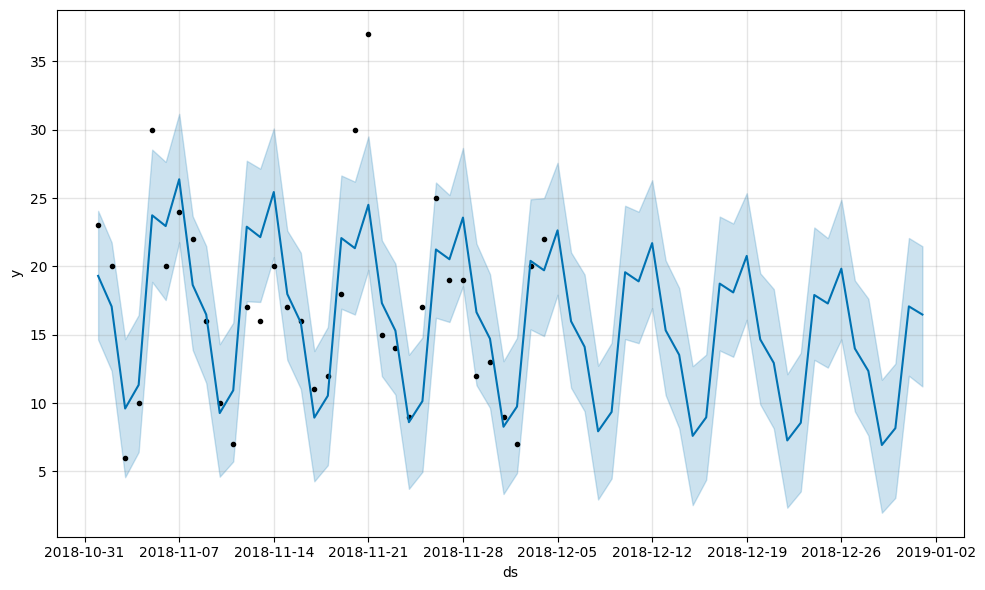

In [20]:
# Get the pickup location for the best model
sample_unique_id = final_df.index[0]

# Get the algorithm used
sample_algorithm = final_df.loc[[sample_unique_id]].algorithm.values[0]

# Get a checkpoint directly from the pandas dataframe of Tune results
checkpoint = final_df.checkpoint[sample_unique_id]
print(f"checkpoint type:: {type(checkpoint)}")

# Restore a model from checkpoint
sample_model = checkpoint.to_dict()["model"]

# Prophet .fit() performs inference + prediction.
# Arima train only performs inference; prediction is an extra step.
if sample_algorithm == "arima":
    prediction = (
        sample_model.forecast(2 * (FORECAST_LENGTH + 1))
        .reset_index()
        .set_index("ds")
    )
    prediction["trend"] = None
    prediction.rename(columns={"AutoARIMA": "yhat"}, inplace=True)
    prediction = prediction.tail(FORECAST_LENGTH + 1)

# Restore already-created predictions from model training and eval
forecast_df = checkpoint.to_dict()["forecast_df"]

# Print pickup location ID, algorithm used, and model validation error.
sample_error = final_df.loc[[sample_unique_id]].error.values[0]
print(
    f"location {sample_unique_id}, algorithm {sample_algorithm}, best error {sample_error}"
)

# Plot forecast prediction using best model for this pickup location ID.
# If prophet model, use prophet built-in plot
if sample_algorithm == "arima":
    forecast_df[["y", "yhat"]].plot()
else:
    plot1 = sample_model.plot(forecast_df)

checkpoint type:: <class 'ray.air.checkpoint.Checkpoint'>
location 237, algorithm prophet_multiplicative, best error 1919.3841489655701


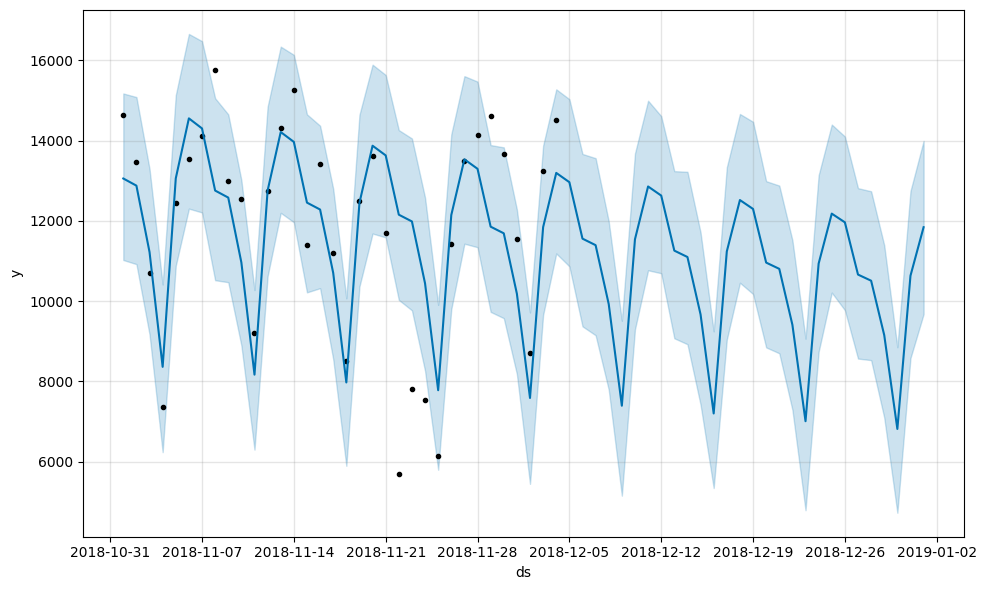

In [21]:
# Get the pickup location for the worst model
sample_unique_id = final_df.index[len(final_df) - 1]

# Get the algorithm used
sample_algorithm = final_df.loc[[sample_unique_id]].algorithm.values[0]

# Get a checkpoint directly from the pandas dataframe of Tune results
checkpoint = final_df.checkpoint[sample_unique_id]
print(f"checkpoint type:: {type(checkpoint)}")

# Restore a model from checkpoint
sample_model = checkpoint.to_dict()["model"]

# Prophet .fit() performs inference + prediction.
# Arima train only performs inference; prediction is an extra step.
if sample_algorithm == "arima":
    prediction = (
        sample_model.forecast(2 * (FORECAST_LENGTH + 1))
        .reset_index()
        .set_index("ds")
    )
    prediction["trend"] = None
    prediction.rename(columns={"AutoARIMA": "yhat"}, inplace=True)
    prediction = prediction.tail(FORECAST_LENGTH + 1)

# Restore already-created predictions from model training and eval
forecast_df = checkpoint.to_dict()["forecast_df"]
# forecast_df = forecast_df.loc[(forecast_df.ds >= MIN_DATE), :]

# Print pickup location ID, algorithm used, and model validation error.
sample_error = final_df.loc[[sample_unique_id]].error.values[0]
print(
    f"location {sample_unique_id}, algorithm {sample_algorithm}, best error {sample_error}"
)

# Plot forecast prediction using best model for this pickup location ID.
# If prophet model, use prophet built-in plot
if sample_algorithm == "arima":
    forecast_df[["y", "yhat"]].plot()
else:
    plot1 = sample_model.plot(forecast_df)

## Deploy a model from checkpoint using Ray Serve <a class="anchor" id="serve_air"></a>

Coding steps for Deployment:
- **Step 1**. Instantiate a batch predictor using Ray AIR checkpoints.
- **Step 2**. Create some test data.
- **Step 3**. Run `batch_predictor.predict(test_data)`.

Replace Step 3 above with these steps for a custom predictor:
- **Step 3**.  Define a Ray Serve deployment class by using a Ray decorator @serve.deployment.
- **Step 4**.  Deploy the predictor.
- **Step 5**.  Query the deployment and get the result.

Steps 3-5 above are only required if you are using a custom predictor (such as ARIMA, Prophet, or PyTorch Forecasting).  Otherwise for Ray AIR-integrated ML Libraries (HuggingFace transformers, PyTorch, TensorFlow, Scikit-learn, XGBoost, or LightGBM models), all you have to do is call `batch_predictor.predict(test_data)`.

For more details see [Ray AIR Predictors](https://docs.ray.io/en/latest/ray-air/predictors.html) and [Ray Serve](https://docs.ray.io/en/latest/serve/getting_started.html) docs.

In [22]:
from ray import serve

In [23]:
# Get location to saved model.
# print(f"checkpoint: {checkpoint}")
# print(f"type model: {type(sample_model)}")

##########
# STEP 1. Instantiate a batch predictor from checkpoint.
##########
batch_predictor = sample_model
print(f"Batch predictor type: {type(batch_predictor)}")

Batch predictor type: <class 'prophet.forecaster.Prophet'>


In [24]:
##########
# STEP 2. Create some test data. 
##########
# Restore validation data from checkpoint.
valid_df = checkpoint.to_dict()['valid_df']

# Being lazy, use validation data as test data
# test_df = preprocess_per_uniqueid(files_to_use[-1:], sample_unique_id)
test_df = valid_df.copy()
test_df["ds"] = test_df["ds"] + timedelta(days=FORECAST_LENGTH)

print(valid_df.shape, test_df.shape)
print(valid_df.tail(2))
print(test_df.head(2))

(28, 3) (28, 3)
    unique_id         ds     y
53        237 2018-12-30  5438
54        237 2018-12-31  7589
    unique_id         ds      y
55        237 2019-01-01  14510
56        237 2019-01-02  14743


In [25]:
##########
# STEP 3. Define a Ray Serve deployment class.
##########
@serve.deployment
class ProphetPredictor:
    def __init__(self, predictor, valid_data, test_data, forecast_length, unique_id):
        self.predictor = predictor
        self.valid_data = valid_data
        self.test_data = test_data
        self.forecast_length = forecast_length
        self.unique_id = unique_id
        
    def predict(self):
        future_dates = self.predictor.make_future_dataframe(
            periods=self.forecast_length, freq="D"
        )
        raw_predictions = \
          self.predictor.predict(future_dates)
        return raw_predictions
    
    def post_process(self, predictions):
        predictions = \
            pd.merge(predictions, self.valid_data[['ds', 'y']], 
                     on=['ds'], how='left')
        predictions = \
            pd.merge(predictions, self.test_data[['ds', 'y']], 
                     on=['ds'], how='left')
        predictions['y'] = predictions.y_x.combine_first(predictions.y_y)
        predictions.drop(['y_x', 'y_y'], inplace=True, axis=1)
        predictions['unique_id'] = self.unique_id
        return predictions
    
    def calc_error(self, future):
        temp = future.copy()
        temp["forecast_error"] = np.abs(temp["yhat"] - temp["y"])
        temp.dropna(inplace=True)
        error = np.mean(temp["forecast_error"])
        return error

    def __call__(self):
        raw_predictions = self.predict()
        predictions = self.post_process(raw_predictions)
        error = self.calc_error(predictions)
        return [error, predictions]
    

In [26]:
##########
# STEP 4. Deploy the predictor.
##########
# Bind arguments to the Class constructor.
my_first_deployment = ProphetPredictor.bind(
    predictor=batch_predictor,
    valid_data=valid_df, 
    test_data=test_df, 
    forecast_length=FORECAST_LENGTH,
    unique_id=sample_unique_id)

##########
# STEP 5. Query the deployment and get the result.
##########
# Get handle from serve.run().
handle = serve.run(my_first_deployment)

# Get ray results from the handle with ray.get().
ray_return = ray.get(handle.remote())
error = ray_return[0]
new_pred = ray_return[1]

print(type(error), type(new_pred))

INFO:/home/ray/anaconda3/lib/python3.8/site-packages/ray/serve/_private/api.py:Connecting to existing Serve app in namespace "serve". New http options will not be applied.
INFO:/home/ray/anaconda3/lib/python3.8/site-packages/ray/serve/_private/client.py:Updating deployment 'ProphetPredictor'. component=serve deployment=ProphetPredictor


(scheduler +3m49s) Failed to launch 1 node(s) of type worker-node-type-0.


INFO:/home/ray/anaconda3/lib/python3.8/site-packages/ray/serve/_private/client.py:Deployment 'ProphetPredictor' is ready at `http://127.0.0.1:8000/`. component=serve deployment=ProphetPredictor


(scheduler +3m54s) Failed to launch 1 node(s) of type worker-node-type-0.
<class 'numpy.float64'> <class 'pandas.core.frame.DataFrame'>


Forecast for location=237, error=2617.09


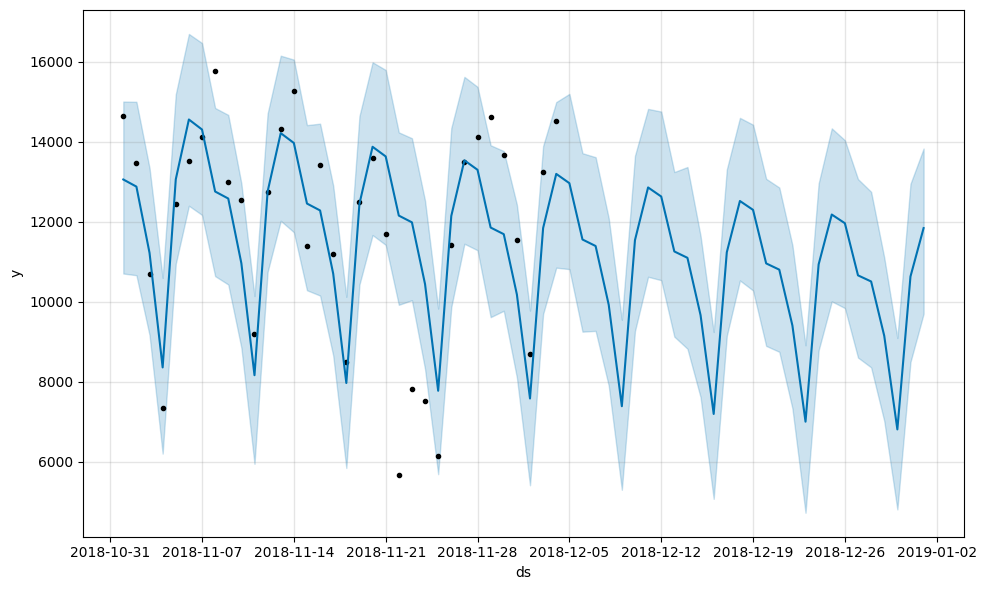

(scheduler +4m1s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +4m7s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +4m12s) Failed to launch 1 node(s) of type worker-node-type-0.
(scheduler +4m18s) Failed to launch 1 node(s) of type worker-node-type-0.


In [27]:
# Plot some predictions from deployed predictor.
print(f"Forecast for location={sample_unique_id}, error={np.round(error, 2)}")
plot1 = batch_predictor.plot(new_pred)